<h1><center><font size="6">Predicting Telco Customer Churn</font></center></h1>

<h2><center><font size="4">Dataset used:Kaggle </font></center></h2>

In [1]:
# Change the feature engineering to include Polynomial Features 
# Include the Bad column identification & removal from previous week
# Get the Feature Reduction part (Collinear columns & those with low feature importances)

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate](#3)
    
1. [Feature Engineering](#4)
    1. [Prepping - Memory Reduction](#41)
    1. [Feature Generation](#42)
        1. [Custom Mathematical Transformation](#422)
        1. [Polynomial Feature Generation](#422)
    
1. [Feature Reduction](#5)
    1. [Eliminating Duplicates and Constant Columns](#51)
    1. [Collinearity-based Reduction](#52)
    1. [Feature Importance-based Reduction](#53)
    1. [Custom Reduction](#54)

1. [Test Performance](#6)
    1. [Data Prep](#61)
        1. [Train Test Split](#611)
        1. [Resample Train Data](#612)
    1. [Modelling Workflow](#62)
    
1. [References](#7)

# <a id='1'>Introduction</a>  

We will use a mix of custom functions and polynomial feature generation API to expand the feature space. Then once the synthetic features are created, we will to reduce the feature space by removing collinear columns and filtering further by the top features from the feature importances. Finally we will run the Random Forest Classifier to get test performance on datasets that have been resampled using the technique identified in the previous analysis.


# <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os
import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") # Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [3]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Churn'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No', 'Yes']

input_file_name =  'WA_Fn-UseC_-Telco-Customer-Churn.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day1_cleaned_df_output_20200501.pkl'
engineered_df_file_name = 'day3_engineered_df_'
output_df_file_name = 'week3_cleaned_df_output_' 

# Enter the date in which this notebook is run
export_date = '20200505'

In [4]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
print(os.listdir('../input'))
# This will list all the files in this folder

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


## <a id='3'>Load Data & Validate</a>  

In [5]:
df = pd.read_csv('../input/' + input_file_name)
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3663,4633-MKHYU,Female,0,No,No,9,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,88.40,788.6,No
2812,3763-GCZHZ,Male,0,Yes,No,66,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,One year,Yes,Electronic check,104.05,6890,Yes
5628,6821-BUXUX,Female,0,No,No,13,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,96.65,1244.5,Yes
4081,7665-TOALD,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,69.60,69.6,Yes
658,4464-JCOLN,Male,0,Yes,Yes,2,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.85,35.9,Yes


Lets check the head & tail to make sure there is nothing going on

In [6]:
df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [7]:
df.tail(3)
# similar logic here

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


No data corruption seen in either the head or the tail

#### <a id = 31> Import cleaned dataframe

In [8]:
import pickle

infile = open(clean_df_file_name,'rb')
clean_df = pickle.load(infile)
infile.close()


## <a id='4'> Feature Engineering  

### <a id='41'> Prepping

We are going to reduce our memory footprint of the stored dataframe to ease the burden on the processing. Subsequently, we are going to cut down on the number of features we want to apply feature engineering on by using the top features identified by a ML classifier like RandomForestClassifier

#### <a id='411'> Memory Reduction

In [9]:
# Check out what the data types are before the more efficient storage occurs
clean_df.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [10]:
%%time
# Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

from helper_functions_comprehensive import reduce_mem_usage_function

clean_df, NA_dict = reduce_mem_usage_function(clean_df)
# There is 2x reduction in the size of the data
# All the float64 got converted to float32

Memory usage of dataframe is 1.13 MB
Column gender dtype after is float32 
******************************
Column SeniorCitizen dtype after is float32 
******************************
Column Partner dtype after is float32 
******************************
Column Dependents dtype after is float32 
******************************
Column tenure dtype after is float32 
******************************
Column PhoneService dtype after is float32 
******************************
Column MultipleLines dtype after is float32 
******************************
Column InternetService dtype after is float32 
******************************
Column OnlineSecurity dtype after is float32 
******************************
Column OnlineBackup dtype after is float32 
******************************
Column DeviceProtection dtype after is float32 
******************************
Column TechSupport dtype after is float32 
******************************
Column StreamingTV dtype after is float32 
*****************************

###### Split Target Features

In [11]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29,29
5575-GNVDE,1.0,0.0,0.0,0.0,34.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56,1889
3668-QPYBK,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53,108
7795-CFOCW,1.0,0.0,0.0,0.0,45.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42,1840
9237-HQITU,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70,151


#### <a id=412 > Selecting top 10 features - Feature Importances

Depending on the resources available, you can go all out and apply feature tools on all the features. But I would recommend just doing it for the top 10 features as defined by the Feature Importances from a simple ML algorithm. Note that since we are not using the fitted model for inferencing, there is no need to do train_test_split. I am going to apply the RandomForestClassifier on the whole dataset

In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 42)

# Fit on the input data
classifier.fit(X, y)

# Get the feature importances
feature_importances = classifier.feature_importances_

# Create a dataframe to hold the feature importances
feature_importances_df = pd.DataFrame({'feature': list(X.columns), 
'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head(10)
# Print from the highest to the lowest feature importance

,feature,importance
18,TotalCharges,0.192667
4,tenure,0.164427
17,MonthlyCharges,0.137609
14,Contract,0.082083
16,PaymentMethod,0.057373
8,OnlineSecurity,0.048122
11,TechSupport,0.045992
0,gender,0.030959
7,InternetService,0.028533
9,OnlineBackup,0.028181


In [13]:
imp_column_list = list(feature_importances_df.head(10)['feature'].values)
imp_column_list
# Now use these moving forward for the automated feature engineering

['TotalCharges',
 'tenure',
 'MonthlyCharges',
 'Contract',
 'PaymentMethod',
 'OnlineSecurity',
 'TechSupport',
 'gender',
 'InternetService',
 'OnlineBackup']

In [14]:
imp_X = X[imp_column_list].copy()
unimp_X = X[list(set(X.columns) - set(imp_column_list))].copy()
# the latter will be later used to concatenate with the engineered features before feature reduction

# pd.concat([engineered_df, inimp_X], axis=1)

assert((len(imp_X.columns) + len(unimp_X.columns)) ==  len(X.columns))

len(imp_X.columns), len(unimp_X.columns), len(X.columns)


(10, 9, 19)

### <a id=42 >Feature Generation

Feature Engineering can based on domain knowledge or clever intuition based on the understanding of the data. But given that this is a Kaggle dataset we cant do either. The next best option is to do combinations of features using mathematical operations which is what we are going to attempt here.

#### <a id=421 > Custom Mathematical Feature Generation

In [15]:
# create a copy of the dataframe that will be holding our engineered variables
engineered_df = imp_X.copy()
engineered_df.head()

,TotalCharges,tenure,MonthlyCharges,Contract,PaymentMethod,OnlineSecurity,TechSupport,gender,InternetService,OnlineBackup
customerID,,,,,,,,,,
7590-VHVEG,29,1.0,29,0.0,2.0,0.0,0.0,0.0,0.0,2.0
5575-GNVDE,1889,34.0,56,1.0,3.0,2.0,0.0,1.0,0.0,0.0
3668-QPYBK,108,2.0,53,0.0,3.0,2.0,0.0,1.0,0.0,2.0
7795-CFOCW,1840,45.0,42,1.0,0.0,2.0,2.0,1.0,0.0,0.0
9237-HQITU,151,2.0,70,0.0,2.0,0.0,0.0,0.0,1.0,0.0


In [16]:
numerical_col_list = ['TotalCharges','MonthlyCharges','tenure']

object_col_list = list(set(imp_X.columns) - set(numerical_col_list))
object_col_list

['OnlineBackup',
 'PaymentMethod',
 'OnlineSecurity',
 'Contract',
 'InternetService',
 'TechSupport',
 'gender']

In [17]:
%%time
# Only apply the transformations on continuous features
for col in numerical_col_list:
    print(col)
    
    engineered_df['square_' + col] = engineered_df[col].apply(lambda x: x*x)

    min_val = engineered_df[col].min()
    # Apply log transformation while ensuring no NaNs are generated
    engineered_df['log_' + col] = engineered_df[col].apply(lambda x: np.log(x-min_val+1))
    
    # Similarly, subtract the min to make sure that the sqrt is always positive
    engineered_df['sqrt_' + col] = engineered_df[col].apply(lambda x: np.sqrt(x-min_val))
        
    # If else function for the reciprocal to work correctly
    engineered_df['reciproc_' + col] = engineered_df[col].apply(lambda x: 1./x if np.abs(x) else 0)
    
print('No. of columns now are {}'.format(len(engineered_df.columns)))

# The number of columns makes sense because 3 original columns *4 operations = 12 new columns

TotalCharges
MonthlyCharges
tenure
No. of columns now are 22
CPU times: user 448 ms, sys: 0 ns, total: 448 ms
Wall time: 446 ms


In [18]:
engineered_df.head()

,TotalCharges,tenure,MonthlyCharges,Contract,PaymentMethod,OnlineSecurity,TechSupport,gender,InternetService,OnlineBackup,...,sqrt_TotalCharges,reciproc_TotalCharges,square_MonthlyCharges,log_MonthlyCharges,sqrt_MonthlyCharges,reciproc_MonthlyCharges,square_tenure,log_tenure,sqrt_tenure,reciproc_tenure
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29,1.0,29,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,3.316625,0.034483,841,2.484907,3.316625,0.034483,1.0,0.000000,0.000000,1.000000
5575-GNVDE,1889,34.0,56,1.0,3.0,2.0,0.0,1.0,0.0,0.0,...,43.255058,0.000529,3136,3.663562,6.164414,0.017857,1156.0,3.526361,5.744563,0.029412
3668-QPYBK,108,2.0,53,0.0,3.0,2.0,0.0,1.0,0.0,2.0,...,9.486833,0.009259,2809,3.583519,5.916080,0.018868,4.0,0.693147,1.000000,0.500000
7795-CFOCW,1840,45.0,42,1.0,0.0,2.0,2.0,1.0,0.0,0.0,...,42.684892,0.000543,1764,3.218876,4.898979,0.023810,2025.0,3.806662,6.633250,0.022222
9237-HQITU,151,2.0,70,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,11.532563,0.006623,4900,3.970292,7.211103,0.014286,4.0,0.693147,1.000000,0.500000


#### <a id=422 > Polynomial Feature Generation

sklearn has a good package called Polynomial Features which is good at generating cross terms

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

How does this work? Basically, the method creates all possible cross terms upto the polynomial degree passed in as a parameter

In [19]:
# This hack is to make the Polynomial cross terms only work on the continuous features
new_math_col_list = list(engineered_df.columns[-(len(numerical_col_list)*4):])
new_math_col_list

['square_TotalCharges',
 'log_TotalCharges',
 'sqrt_TotalCharges',
 'reciproc_TotalCharges',
 'square_MonthlyCharges',
 'log_MonthlyCharges',
 'sqrt_MonthlyCharges',
 'reciproc_MonthlyCharges',
 'square_tenure',
 'log_tenure',
 'sqrt_tenure',
 'reciproc_tenure']

In [20]:
%%time
from sklearn.preprocessing import PolynomialFeatures

poly_object = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# Note that I have changed the include_bias to False, otherwise it creates a column of 1s

poly_df = pd.DataFrame(poly_object.fit_transform(engineered_df[numerical_col_list + new_math_col_list]),
                        columns = list(poly_object.get_feature_names(
                            engineered_df[numerical_col_list+new_math_col_list].columns)),
                      index=engineered_df.index)

# How do you figure out the number of new columns being generated?
# https://math.stackexchange.com/questions/1424824/general-formula-for-number-of-terms-in-an-expansion

CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 35 ms


In [21]:
poly_df.head()
# you start seeing both square terms as well as cross-terms between the variables

,TotalCharges,MonthlyCharges,tenure,square_TotalCharges,log_TotalCharges,sqrt_TotalCharges,reciproc_TotalCharges,square_MonthlyCharges,log_MonthlyCharges,sqrt_MonthlyCharges,...,reciproc_MonthlyCharges square_tenure,reciproc_MonthlyCharges log_tenure,reciproc_MonthlyCharges sqrt_tenure,reciproc_MonthlyCharges reciproc_tenure,square_tenure log_tenure,square_tenure sqrt_tenure,square_tenure reciproc_tenure,log_tenure sqrt_tenure,log_tenure reciproc_tenure,sqrt_tenure reciproc_tenure
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.0,29.0,1.0,841.0,2.484907,3.316625,0.034483,841.0,2.484907,3.316625,...,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
5575-GNVDE,1889.0,56.0,34.0,3568321.0,7.534763,43.255058,0.000529,3136.0,3.663562,6.164414,...,20.642857,0.062971,0.102581,0.000525,4076.472766,6640.714419,34.0,20.257399,0.103716,0.168958
3668-QPYBK,108.0,53.0,2.0,11664.0,4.510860,9.486833,0.009259,2809.0,3.583519,5.916080,...,0.075472,0.013078,0.018868,0.009434,2.772589,4.000000,2.0,0.693147,0.346574,0.500000
7795-CFOCW,1840.0,42.0,45.0,3385600.0,7.508239,42.684892,0.000543,1764.0,3.218876,4.898979,...,48.214286,0.090635,0.157935,0.000529,7708.491542,13432.330401,45.0,25.250542,0.084592,0.147406
9237-HQITU,151.0,70.0,2.0,22801.0,4.897840,11.532563,0.006623,4900.0,3.970292,7.211103,...,0.057143,0.009902,0.014286,0.007143,2.772589,4.000000,2.0,0.693147,0.346574,0.500000


In [22]:
object_col_list

['OnlineBackup',
 'PaymentMethod',
 'OnlineSecurity',
 'Contract',
 'InternetService',
 'TechSupport',
 'gender']

In [23]:
# combine the above poly_df with the discrete part of engineered_df
engineered_df = pd.concat([engineered_df[object_col_list], poly_df], axis=1)

In [24]:
print('There are currently {} columns'.format(len(engineered_df.columns)))
# Note some redundant columns will be generated because we took the square of some square root terms from before   

There are currently 127 columns


##### Reduce Memory

In [25]:
%%time
# Lets try reducing the memory footprint
features, NAlist = reduce_mem_usage_function(engineered_df)

Memory usage of dataframe is 6.68 MB
Column OnlineBackup dtype after is float32 
******************************
Column PaymentMethod dtype after is float32 
******************************
Column OnlineSecurity dtype after is float32 
******************************
Column Contract dtype after is float32 
******************************
Column InternetService dtype after is float32 
******************************
Column TechSupport dtype after is float32 
******************************
Column gender dtype after is float32 
******************************
Column TotalCharges dtype after is uint16 
******************************
Column MonthlyCharges dtype after is uint8 
******************************
Column tenure dtype after is float32 
******************************
Column square_TotalCharges dtype after is uint32 
******************************
Column log_TotalCharges dtype after is float32 
******************************
Column sqrt_TotalCharges dtype after is float32 
****************

Column reciproc_TotalCharges log_MonthlyCharges dtype after is float32 
******************************
Column reciproc_TotalCharges sqrt_MonthlyCharges dtype after is float32 
******************************
Column reciproc_TotalCharges reciproc_MonthlyCharges dtype after is float32 
******************************
Column reciproc_TotalCharges square_tenure dtype after is float32 
******************************
Column reciproc_TotalCharges log_tenure dtype after is float32 
******************************
Column reciproc_TotalCharges sqrt_tenure dtype after is float32 
******************************
Column reciproc_TotalCharges reciproc_tenure dtype after is float32 
******************************
Column square_MonthlyCharges log_MonthlyCharges dtype after is uint16 
******************************
Column square_MonthlyCharges sqrt_MonthlyCharges dtype after is uint32 
******************************
Column square_MonthlyCharges reciproc_MonthlyCharges dtype after is uint8 
****************

Now lets combine with the rest of the unimportant features

Why are you combining the previously identified low important features if you know that you will be dropping a significant number of features further down the code?

Because the old unimportant features may actually  be higher ranked than some of the newer synthetic features

In [26]:
engineered_df = pd.concat([engineered_df, unimp_X], axis=1)
engineered_df.head()

,OnlineBackup,PaymentMethod,OnlineSecurity,Contract,InternetService,TechSupport,gender,TotalCharges,MonthlyCharges,tenure,...,sqrt_tenure reciproc_tenure,StreamingTV,StreamingMovies,SeniorCitizen,Partner,MultipleLines,PhoneService,PaperlessBilling,Dependents,DeviceProtection
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2.0,2.0,0.0,0.0,0.0,0.0,0.0,29,29,1.0,...,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5575-GNVDE,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1889,56,34.0,...,0.168958,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3668-QPYBK,2.0,3.0,2.0,0.0,0.0,0.0,1.0,108,53,2.0,...,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7795-CFOCW,0.0,0.0,2.0,1.0,0.0,2.0,1.0,1840,42,45.0,...,0.147406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
9237-HQITU,0.0,2.0,0.0,0.0,1.0,0.0,0.0,151,70,2.0,...,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## <a id='5'> Feature Reduction  

### <a id='51'> Identify & Remove Constant or Duplicate Columns  

For our dataset, its highly unlikely we have duplicate columns because they are not categorical. But there are cross terms like sq() of sqrt() which will give you back the original feature

In [27]:
%%time

from helper_functions_comprehensive import find_bad_columns_function

null_col_list, blank_space_col_list, constant_numeric_col_list, \
constant_non_numeric_col_list, duplicate_col_list = find_bad_columns_function(engineered_df)

print('Before dropping irrelevant features and duplicated columns,')
print('{} number of columns were present'.format(len(engineered_df.columns)))

Identified 0 features with atleast one null
Identified 0 features with atleast one blank space
Identified 9 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values
Identified 3 features that are duplicates of other features
Before dropping irrelevant features and duplicated columns,
136 number of columns were present
CPU times: user 2.22 s, sys: 132 ms, total: 2.36 s
Wall time: 2 s


In [28]:
%%time

already_dropped_col_set = set()
for drop_column_list in [null_col_list, constant_numeric_col_list, 
                         constant_non_numeric_col_list, duplicate_col_list]:
    
    # This is just to prevent error messages
    to_drop_set = set(drop_column_list) - already_dropped_col_set
    
    # Drop the above but only those that have not already been dropped     
    features.drop(to_drop_set, axis=1, inplace=True)
    
    #### Store the deleted columns
    already_dropped_col_set.update(to_drop_set)

print('After dropping the above, ')
print('{} number of columns are present'.format(len(features.columns)))


After dropping the above, 
117 number of columns are present
CPU times: user 216 ms, sys: 12 ms, total: 228 ms
Wall time: 34.4 ms


### <a id='52'> Identify & Remove Collinear Features  

Collinear variables are those which are highly correlated with one another. These can decrease the model's ability to learn, model interpretability, and generalization performance on the test set. 
What criteria should we use to remove them once identified? We will take features having more than 0.8 collinearity with another variable

Some source code is adapted from Chris Albon and Will Koehrsen

https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [29]:
%%time

# Threshold for removing correlated variables. This is arbitrary and can itself be a hyperparam
collinearity_threshold = 0.80

# Absolute value correlation matrix. 
# The default in Pearson but you should use Spearman for Ordinal categoricals
corr_matrix_df = engineered_df.corr().abs()

# Upper triangle of correlations
# np.triu returns a matrix with elements below the kth diagonal zeroed
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu.html

# Create a mask with the above and store just the upper triangular values 
# Because they are the only useful ones anyway

upper_df = corr_matrix_df.where(np.triu(np.ones(corr_matrix_df.shape), k=1).astype(np.bool))
upper_df.head()

CPU times: user 1.76 s, sys: 140 ms, total: 1.9 s
Wall time: 804 ms


In [30]:
%%time
# Select columns with correlations above 80% threshold
collinear_columns_list = [column for column in upper_df.columns 
                          if any(upper_df[column] > collinearity_threshold)]

print('There are {} columns to remove'.format(len(collinear_columns_list)))

There are 109 columns to remove
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50.8 ms


##### Drop the columns

In [31]:
engineered_df = engineered_df.drop(columns = collinear_columns_list)

print('Features shape: ', engineered_df.shape)

Features shape:  (7032, 27)


### <a id='53'> Identify & remove low important features

lets use a simple classifier like Random Forest to figure out the top features

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(engineered_df, y)

# Record the feature importances
feature_importances = classifier.feature_importances_

feature_importances_df = pd.DataFrame({'feature': list(engineered_df.columns), 
'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head()
# Print from the highest to the lowest

CPU times: user 1.3 s, sys: 8 ms, total: 1.31 s
Wall time: 1.31 s


In [33]:
# Find the features with zero importance
zero_features_list = list(feature_importances_df[
                        feature_importances_df['importance'] == 0.000]['feature'])
print('There are {} features with 0 importance'.format(len(zero_features_list)))
feature_importances_df.tail()

There are 3 features with 0 importance


,feature,importance
18,StreamingTV,0.009032
23,PhoneService,0.002593
11,MonthlyCharges reciproc_MonthlyCharges,0.000000
10,TotalCharges reciproc_TotalCharges,0.000000
13,tenure reciproc_tenure,0.000000


Depending on the problem we can choose to remove just those features with 0 importance or formally establish a threshold for identify and drop those with low feature importance

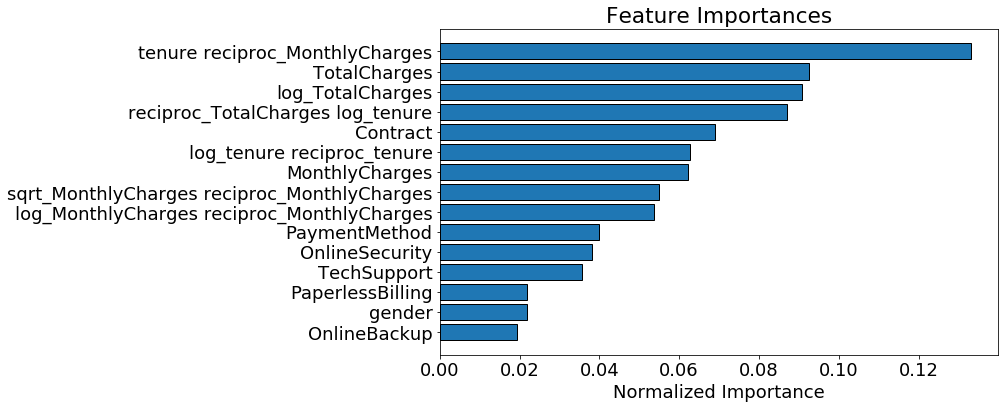

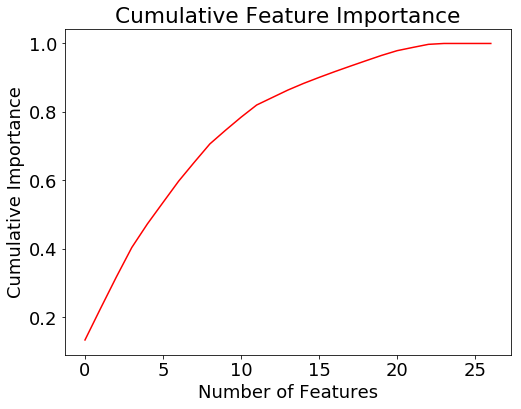

16 features required for 0.9 of cumulative importance


In [34]:
from helper_functions_comprehensive import plot_feature_importances
norm_feature_importances_df, no_of_important_col = plot_feature_importances(feature_importances_df, threshold = 0.90)

In [35]:
norm_feature_importances_df.head()
# Notice how some of the engineered features are supposedly better than the original features

,index,feature,importance,importance_normalized,cumulative_importance
0,12,tenure reciproc_MonthlyCharges,0.133172,0.133172,0.133172
1,7,TotalCharges,0.092482,0.092482,0.225653
2,9,log_TotalCharges,0.090821,0.090821,0.316474
3,14,reciproc_TotalCharges log_tenure,0.087145,0.087145,0.403619
4,3,Contract,0.068975,0.068975,0.472594


In [36]:
# Lets use no_of_important_col as the row index to get the names of the features 
relevant_feature_list = (norm_feature_importances_df['feature'].values)[:no_of_important_col]

In [37]:
import pickle
# This will export the engineered_df 
pickle.dump(engineered_df, open(engineered_df_file_name + export_date + '.pkl', 'wb'))

In [38]:
#Keep these highest importance features
engineered_df = engineered_df[relevant_feature_list].copy()
engineered_df.shape

(7032, 16)

In [39]:
engineered_df.head()

,tenure reciproc_MonthlyCharges,TotalCharges,log_TotalCharges,reciproc_TotalCharges log_tenure,Contract,log_tenure reciproc_tenure,MonthlyCharges,sqrt_MonthlyCharges reciproc_MonthlyCharges,log_MonthlyCharges reciproc_MonthlyCharges,PaymentMethod,OnlineSecurity,TechSupport,PaperlessBilling,gender,OnlineBackup,Partner
customerID,,,,,,,,,,,,,,,,
7590-VHVEG,0.034483,29,2.484907,0.000000,0.0,0.000000,29,0.114366,0.085686,2.0,0.0,0.0,1.0,0.0,2.0,1.0
5575-GNVDE,0.607143,1889,7.534763,0.001867,1.0,0.103716,56,0.110079,0.065421,3.0,2.0,0.0,0.0,1.0,0.0,0.0
3668-QPYBK,0.037736,108,4.510859,0.006418,0.0,0.346574,53,0.111624,0.067614,3.0,2.0,0.0,1.0,1.0,2.0,0.0
7795-CFOCW,1.071429,1840,7.508239,0.002069,1.0,0.084592,42,0.116642,0.076640,0.0,2.0,2.0,0.0,1.0,0.0,0.0
9237-HQITU,0.028571,151,4.897840,0.004590,0.0,0.346574,70,0.103016,0.056718,2.0,0.0,0.0,1.0,0.0,0.0,0.0


### <a id = 54> Custom Feature Removal

We dont need to do any custom feature reduction because the 16 features remaining are manageable

In [40]:
# no_of_feature_cutoff = 30

# # The first priority should be the original set of features that are also present in our top 150 from above
# final_feature_list = [col for col in relevant_feature_list if col in imp_column_list]

# # Only look to add the remaining features that were not in the original top columns list
# for i, col in enumerate(relevant_feature_list):
#     final_feature_list.append(col)
#     print(col)
#     if len(final_feature_list)==no_of_feature_cutoff:
#         break

## <a id='6'>Test Performance</a> 

### <a id='61'>Data Prep</a> 

#### <a id='611'>Train Test Split</a> 

In [41]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(engineered_df[relevant_feature_list[:25]], 
                                                    y, test_size=0.2, random_state=42)

#### <a id='612'>Resample Training Data

In [43]:
# Generate the resampled data using one of the imblearn methods
from imblearn.combine import SMOTEENN

X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)
print(X_resampled_train.shape,sum(y_resampled_train))

(4677, 16) 2521.0


### <a id='62'>Modelling Workflow</a> 

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Has a Test accuracy of 74.0 % 
              precision    recall  f1-score   support

          No       0.87      0.75      0.81      1033
         Yes       0.50      0.70      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407

The ROC AUC Score on Test set is 0.81
Confusion matrix, without normalization
[[775 258]
 [111 263]]


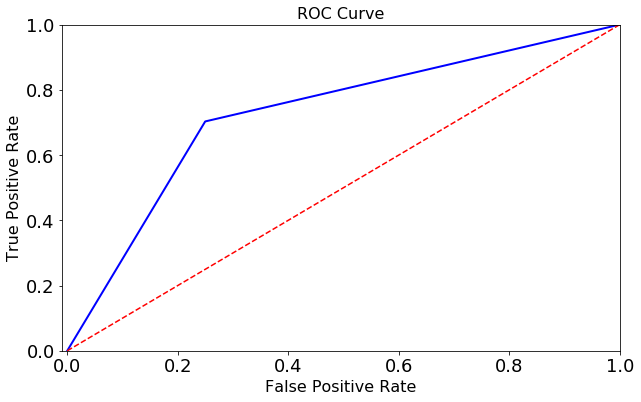

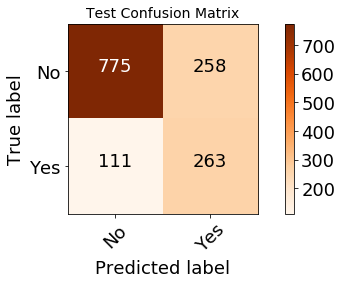

In [45]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [47]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(
                        y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.4167758846657929


In [ ]:
# The test metric is worse than with just the pure resampling. So start with cleaned dataset in Day4

In the interests of time, I have not played around with how many features and subsequently didnt use the feature engineered
dataframe in further weeks. But the reader is invited to try them out with hyperparam tuning

## <a id=8 > References

sklearn documentation on Polynomial Feature Generation
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Examples on stackoverflow in using this 
https://stackoverflow.com/questions/36728287/sklearn-preprocessing-polynomialfeatures-how-to-keep-column-names-headers-of

Removing collinear features
https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection


In [ ]:
# In week 4, we will be starting again from the exported data from week 2 and try hyperparam tuning